In [2]:
import os
from sqlalchemy import create_engine, text
from sqlalchemy.engine import URL
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet

In [2]:
pip install pg8000

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 28.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
url = URL.create(
    "postgresql+pg8000",
    username=os.environ.get('DB_USER'),
    password=os.environ.get('DB_PASSWORD'),
    host=os.environ.get('DB_HOST'),
    database=os.environ.get('DB_NAME')
)

engine = create_engine(url)

NameError: name 'URL' is not defined

In [4]:
with engine.connect() as conn:
    weather_station_coords = pd.read_sql(sql=text("SELECT DISTINCT latitude, longitude FROM weather_historical;"), con=conn)

In [5]:
with engine.connect() as conn:
    population_centers = pd.read_sql(sql=text("SELECT * FROM population_centers WHERE center_name IN ('boston', 'hartford');"), con=conn)   

In [6]:
weather_station_coords['type'] = "weather_station"
population_center_coords = population_centers[['latitude', 'longitude']]
population_center_coords['type'] = "population_center"
all_coords = pd.concat([population_center_coords, weather_station_coords], axis=0, ignore_index=True)

/tmp/ipykernel_1107/3508199798.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  population_center_coords['type'] = "population_center"


(-73.76439500000001, -67.507705, 40.85194, 47.59186)

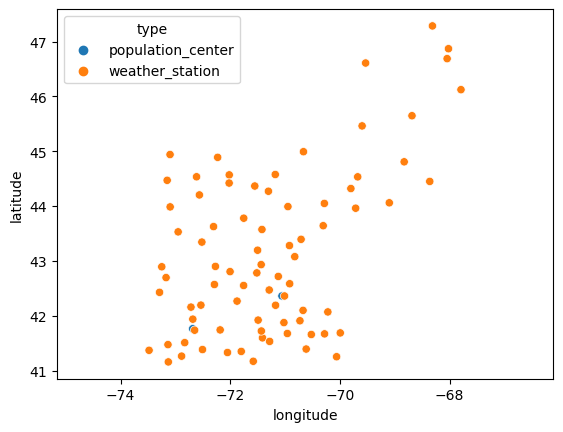

In [7]:
sns.scatterplot(all_coords, x='longitude', y='latitude', hue='type')
plt.axis('equal')

In [8]:
all_coords

,latitude,longitude,type
0,42.361145,-71.05708,population_center
1,41.763710,-72.68510,population_center
2,42.191200,-71.17330,weather_station
3,43.985500,-73.09550,weather_station
4,41.741900,-72.18360,weather_station
...,...,...,...
77,42.098200,-70.67210,weather_station
78,42.570100,-72.28860,weather_station
79,41.158300,-73.12890,weather_station
80,42.893500,-73.24860,weather_station


<Axes: xlabel='longitude', ylabel='latitude'>

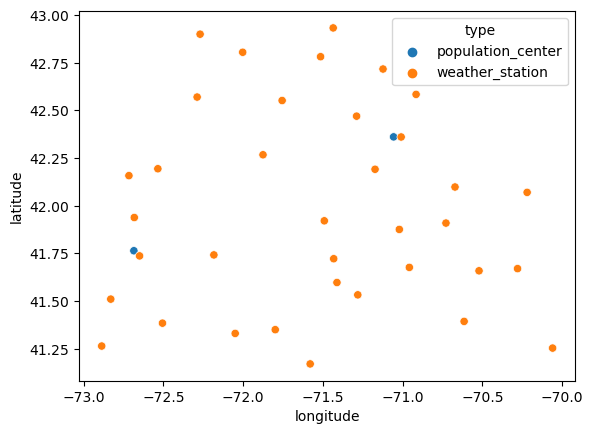

In [9]:
relevant_points = all_coords[(all_coords['latitude'].between(41, 43)) & (all_coords['longitude'].between(-73, -70))]
sns.scatterplot(relevant_points, x='longitude', y='latitude', hue='type')

In [10]:
c = cdist(relevant_points.loc[relevant_points['type'] == 'weather_station', ['longitude', 'latitude']], relevant_points.loc[relevant_points['type'] == 'population_center', ['longitude', 'latitude']], 'euclidean')
distances = pd.DataFrame(c, columns=['distance_to_boston', 'distance_to_hartford'])

In [11]:
distances

,distance_to_boston,distance_to_hartford
0,0.205884,1.571078
1,1.285501,0.501974
2,1.431485,0.769062
3,0.621658,1.551164
4,1.710384,0.044766
5,0.883491,2.166157
6,0.685669,1.711073
7,1.747595,0.419962
8,1.490414,2.674004
9,0.724291,1.218541


(-0.05692527596842474,
 2.2378597520050385,
 -0.08669548755736906,
 2.8054659234720445)

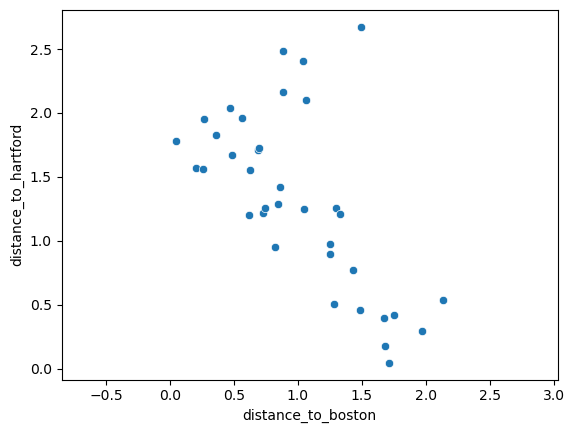

In [12]:
g = sns.scatterplot(distances, x='distance_to_boston', y='distance_to_hartford')
plt.axis('equal')

In [13]:
X = distances.to_numpy()

In [14]:
distortions = []
inertias = []
silhouettes = []
mapping1 = {}
mapping2 = {}
mapping3 = {}
labels = {}

cluster_amount = range(2, 15)
for n in cluster_amount:
    kmeans = KMeans(n_clusters=n, n_init=10)
    kmeans.fit(X)
    silhouettes.append(metrics.silhouette_score(X, kmeans.labels_, metric='euclidean'))
    distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeans.inertia_)
    mapping1[n] = sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]
    mapping2[n] = kmeans.inertia_
    mapping3[n] = metrics.silhouette_score(X, kmeans.labels_, metric='euclidean')
    labels[n] = kmeans.labels_

<Axes: >

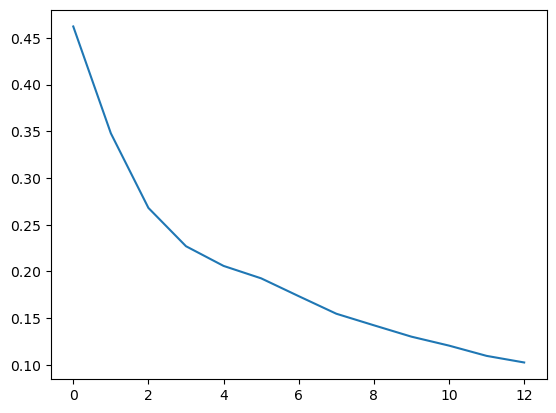

In [15]:
sns.lineplot(distortions)

<Axes: >

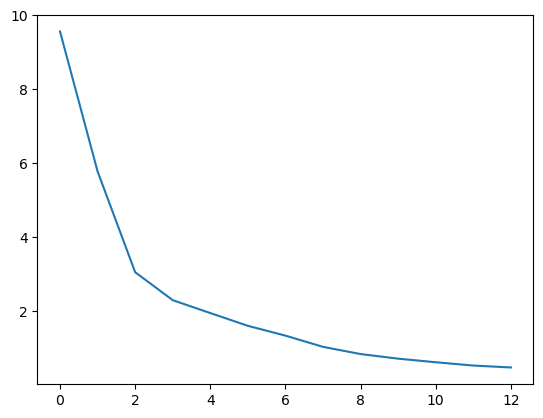

In [16]:
sns.lineplot(inertias)

<Axes: >

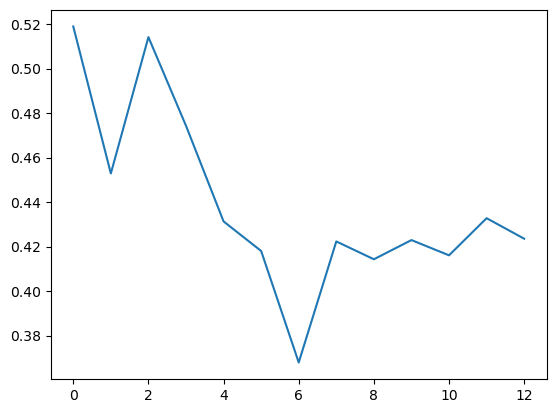

In [17]:
sns.lineplot(silhouettes)

In [18]:
labels[2]

array([0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0], dtype=int32)

In [19]:
relevant_points['label'] = 'population_center'
relevant_points.loc[2:, 'label'] = labels[2]
relevant_points

/tmp/ipykernel_1107/1591246521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_points['label'] = 'population_center'


,latitude,longitude,type,label
0,42.361145,-71.05708,population_center,population_center
1,41.763710,-72.68510,population_center,population_center
2,42.191200,-71.17330,weather_station,0
4,41.741900,-72.18360,weather_station,1
7,41.330000,-72.05000,weather_station,1
8,42.781800,-71.51480,weather_station,0
9,41.736700,-72.64940,weather_station,1
10,41.658500,-70.52150,weather_station,0
11,42.932800,-71.43570,weather_station,0
15,41.383900,-72.50590,weather_station,1


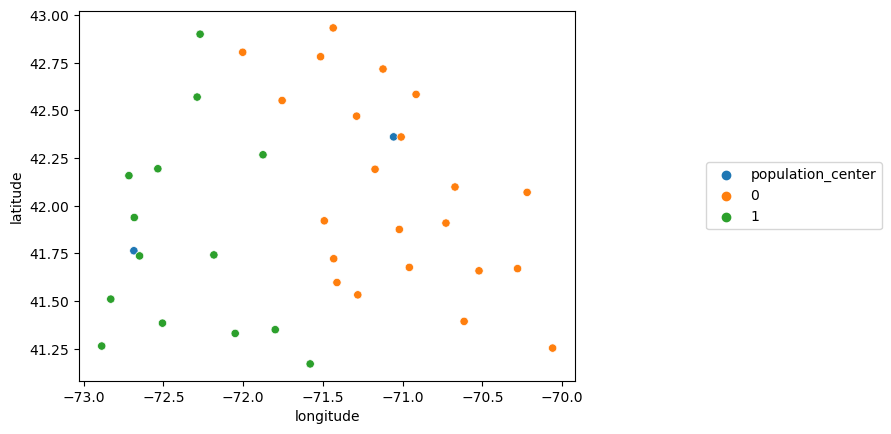

In [20]:
g = sns.scatterplot(relevant_points, x='longitude', y='latitude', hue='label')
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

In [21]:
hartford_area = tuple(relevant_points.loc[relevant_points['label'] == 1, ['latitude', 'longitude']].itertuples(index=False, name=None))
boston_area = tuple(relevant_points.loc[relevant_points['label'] == 0, ['latitude', 'longitude']].itertuples(index=False, name=None))
area_params = [boston_area, hartford_area]

In [22]:
dfs = list()

with engine.connect() as conn:
    for params in area_params:
        values = ", ".join(str((str(lat), str(lon))) for (lat, lon) in params)
        stmt = '''SELECT 
            weather_datetime, 
            AVG(NULLIF(apparent_temperature, 'NaN')) apparent_temperature_avg, 
            AVG(NULLIF(air_temperature, 'NaN')) air_temperature_avg, 
            AVG(NULLIF(dewpoint_temperature, 'NaN')) dewpoint_temperature_avg,
            AVG(NULLIF(relative_humidity, 'NaN')) relative_humidity_avg,
            AVG(NULLIF(total_precipitation, 'NaN')) total_precipitation_avg, 
            AVG(NULLIF(wind_speed, 'NaN')) wind_speed_avg
            FROM weather_historical
            WHERE (latitude, longitude) IN ({})
            GROUP BY weather_datetime
            ORDER BY weather_datetime ASC;'''.format(values)
        df = pd.read_sql(sql=text(stmt), con=conn)
        dfs.append(df)

In [23]:
with engine.connect() as conn:
    load_historical = pd.read_sql(sql=text("SELECT DISTINCT load_datetime, load_mw FROM grid_load;"), con=conn)

In [73]:
stmt = """SELECT DISTINCT gf.forecasted_at, gf.forecasted_for, gf.load_mw FROM grid_forecast gf 
INNER JOIN (SELECT MAX(forecasted_at) MaxDate, forecasted_for FROM grid_forecast group by forecasted_for) tm
ON tm.forecasted_for = gf.forecasted_for AND gf.forecasted_at = tm.MaxDate;"""
with engine.connect() as conn:
    load_forecast = pd.read_sql(sql=text(stmt), con=conn)

NameError: name 'engine' is not defined

In [25]:
boston_area_weather = dfs[0].rename(columns={c:'boston_area_'+c for c in dfs[0].columns if c not in ['weather_datetime']})
hartford_area_weather = dfs[1].rename(columns={c:'hartford_area_'+c for c in dfs[1].columns if c not in ['weather_datetime']})

In [26]:
two_cluster_weather = boston_area_weather.merge(hartford_area_weather, on='weather_datetime', how='inner')
two_cluster_weather['weather_datetime'] = two_cluster_weather['weather_datetime'].astype('datetime64')

In [30]:
load_historical = load_historical.drop_duplicates()

In [31]:
data = (
    two_cluster_weather
    .merge(
        load_historical, 
        left_on='weather_datetime', 
        right_on='load_datetime', 
        how='inner', indicator=True)
    .drop(columns=['_merge', 'weather_datetime'])
)

In [5]:
data = pd.read_csv('../analysis/clean_data.csv', index_col=0)
data

,boston_area_apparent_temperature_avg,boston_area_air_temperature_avg,boston_area_dewpoint_temperature_avg,boston_area_relative_humidity_avg,boston_area_total_precipitation_avg,boston_area_wind_speed_avg,hartford_area_apparent_temperature_avg,hartford_area_air_temperature_avg,hartford_area_dewpoint_temperature_avg,hartford_area_relative_humidity_avg,hartford_area_total_precipitation_avg,hartford_area_wind_speed_avg,load_datetime,load_mw
0,32.062857,38.142858,32.914285,81.734286,0.520000,9.019524,34.165714,38.477143,36.062143,91.049999,1.905714,6.956429,2019-01-01 01:00:00,11496.656
1,31.107143,37.592858,34.339524,88.272858,1.558571,9.614762,32.799286,38.524286,36.746429,93.399285,4.116429,9.440000,2019-01-01 02:00:00,11368.765
2,30.134286,37.329524,34.856190,90.816666,3.059524,11.066667,33.081429,39.167857,37.264285,92.940000,4.355714,10.520000,2019-01-01 03:00:00,11270.259
3,30.843333,38.037143,35.559047,91.044762,3.000476,11.940952,34.318572,39.656428,38.322857,95.037857,6.132857,9.850000,2019-01-01 04:00:00,11309.606
4,31.741500,38.882500,36.663500,92.064500,5.599000,12.382500,35.850000,40.370714,39.013572,94.942143,5.570000,9.125714,2019-01-01 05:00:00,11516.118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37019,52.330476,53.761905,42.754762,68.240953,0.057727,11.829048,50.293076,51.110769,46.752308,85.290769,0.780714,10.232857,2023-03-23 19:00:00,13881.286
37020,49.870476,51.921428,44.487143,77.743809,0.207273,12.129524,49.656154,50.735384,47.620770,89.139231,0.432143,9.624286,2023-03-23 20:00:00,13472.341
37021,49.795238,51.688096,46.388095,83.216191,0.264545,11.782857,50.168461,51.066923,47.878462,89.037693,0.017857,9.132143,2023-03-23 21:00:00,12674.921
37022,49.491905,51.505714,46.634286,84.262857,0.000000,11.681905,50.516153,51.446153,48.230770,88.896154,0.000000,9.528571,2023-03-23 22:00:00,11677.522


In [59]:
data['load_datetime'] = pd.to_datetime(data['load_datetime'])

In [60]:
data['is_weekday'] = np.where(data['load_datetime'].dt.dayofweek >= 5, 0, 1)
data['is_weekday'].value_counts()

1    26465
0    10559
Name: is_weekday, dtype: int64

In [61]:
prophet_train = data.loc[:np.ceil(.8*len(data)),['load_datetime','boston_area_apparent_temperature_avg', 'hartford_area_apparent_temperature_avg', 'load_mw', 'is_weekday']].rename({'load_datetime': 'ds', 'load_mw': 'y'}, axis=1).sort_values('ds')
prophet_test = data.loc[np.ceil(.8*len(data)):,['load_datetime','boston_area_apparent_temperature_avg', 'hartford_area_apparent_temperature_avg', 'load_mw', 'is_weekday']].rename({'load_datetime': 'ds', 'load_mw': 'y'}, axis=1).sort_values('ds')

In [62]:
m = Prophet()
m.add_country_holidays(country_name='US')
m.add_regressor('boston_area_apparent_temperature_avg')
m.add_regressor('hartford_area_apparent_temperature_avg')
m.add_regressor('is_weekday')
m.fit(prophet_train)

00:21:49 - cmdstanpy - INFO - Chain [1] start processing
00:22:32 - cmdstanpy - INFO - Chain [1] done processing


In [63]:
predictions = m.predict(prophet_test)

In [71]:
merged_y_yhat = predictions[['ds', 'yhat']].merge(prophet_test[['y', 'ds']]).set_index('ds')
merged_y_yhat

,yhat,y
ds,,
2022-05-19 10:00:00,11835.692309,13117.797
2022-05-19 11:00:00,11790.086321,13199.001
2022-05-19 12:00:00,11842.134383,13205.589
2022-05-19 13:00:00,11978.674234,13116.635
2022-05-19 14:00:00,12189.353706,12934.000
...,...,...
2023-03-23 19:00:00,12732.469586,13881.286
2023-03-23 20:00:00,12136.100654,13472.341
2023-03-23 21:00:00,11209.278897,12674.921


<Axes: xlabel='ds'>

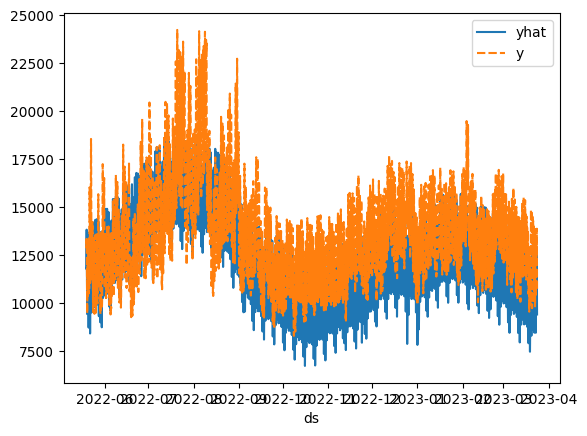

In [72]:
sns.lineplot(merged_y_yhat)

In [51]:
predictions

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-05-19 10:00:00,12648.668211,10046.587328,13567.149176,12648.668211,12648.668211,0.0,0.0,0.0,0.0,...,233.259529,233.259529,233.259529,-1716.255273,-1716.255273,-1716.255273,0.0,0.0,0.0,11835.692309
1,2022-05-19 11:00:00,12648.441904,9888.312901,13530.104471,12648.441904,12648.441904,0.0,0.0,0.0,0.0,...,227.453181,227.453181,227.453181,-1713.741283,-1713.741283,-1713.741283,0.0,0.0,0.0,11790.086321
2,2022-05-19 12:00:00,12648.215597,10170.491367,13513.653830,12648.215597,12648.215597,0.0,0.0,0.0,0.0,...,221.259015,221.259015,221.259015,-1711.218789,-1711.218789,-1711.218789,0.0,0.0,0.0,11842.134383
3,2022-05-19 13:00:00,12647.989291,10225.408691,13702.879073,12647.989291,12647.989291,0.0,0.0,0.0,0.0,...,214.725061,214.725061,214.725061,-1708.687806,-1708.687806,-1708.687806,0.0,0.0,0.0,11978.674234
4,2022-05-19 14:00:00,12647.762984,10419.968719,13802.275666,12647.762984,12647.762984,0.0,0.0,0.0,0.0,...,207.898860,207.898860,207.898860,-1706.148348,-1706.148348,-1706.148348,0.0,0.0,0.0,12189.353706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7399,2023-03-23 19:00:00,10973.770709,2271.715040,21778.907783,419.928790,19976.388934,0.0,0.0,0.0,0.0,...,170.900160,170.900160,170.900160,-1073.701535,-1073.701535,-1073.701535,0.0,0.0,0.0,12732.469586
7400,2023-03-23 20:00:00,10973.544402,1332.098645,21165.461283,415.969683,19977.910852,0.0,0.0,0.0,0.0,...,163.179898,163.179898,163.179898,-1075.733095,-1075.733095,-1075.733095,0.0,0.0,0.0,12136.100654
7401,2023-03-23 21:00:00,10973.318095,989.727646,20272.858510,412.010575,19979.432769,0.0,0.0,0.0,0.0,...,155.414513,155.414513,155.414513,-1077.759650,-1077.759650,-1077.759650,0.0,0.0,0.0,11209.278897
7402,2023-03-23 22:00:00,10973.091788,-498.804782,19292.367560,408.051468,19980.954687,0.0,0.0,0.0,0.0,...,147.618755,147.618755,147.618755,-1079.781204,-1079.781204,-1079.781204,0.0,0.0,0.0,10221.880239


In [53]:
prophet_test

,ds,boston_area_apparent_temperature_avg,hartford_area_apparent_temperature_avg,y,is_weekday
29620,2022-05-19 10:00:00,54.828572,52.665833,13117.797,1
29621,2022-05-19 11:00:00,54.890477,52.884615,13199.001,1
29622,2022-05-19 12:00:00,55.145455,52.942307,13205.589,1
29623,2022-05-19 13:00:00,55.404546,53.140769,13116.635,1
29624,2022-05-19 14:00:00,55.382273,53.659230,12934.000,1
...,...,...,...,...,...
37019,2023-03-23 19:00:00,52.330476,50.293076,13881.286,1
37020,2023-03-23 20:00:00,49.870476,49.656154,13472.341,1
37021,2023-03-23 21:00:00,49.795238,50.168461,12674.921,1
37022,2023-03-23 22:00:00,49.491905,50.516153,11677.522,1
